In [1]:
#TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import sklearn.feature_extraction.text as sk_text 
import numpy as np
import pandas as pd


In [2]:
dataset = pd.read_csv("../drugsCom_raw/cleaned_data.csv")

In [3]:
dataset["review"].str.len().describe()

count    213867.000000
mean        437.597671
std         230.879359
min           1.000000
25%         250.000000
50%         435.000000
75%         660.000000
max       10265.000000
Name: review, dtype: float64

In [4]:
dataset["review"] = dataset["review"].str.replace('\\r\\n',' ',regex=True)

## TF-IDF Vectorizer


In [5]:
from numpy import hstack
from keras.utils import np_utils

In [20]:
def TFIDF(df_train,df_test,min_gram,max_gram,num_features=1200):
    vectorizer = sk_text.TfidfVectorizer(stop_words='english',ngram_range=(min_gram,max_gram),max_features=num_features,min_df=2)
    print(vectorizer)
    train_data_features = vectorizer.fit_transform(df_train["review"])
    test_data_features = vectorizer.transform(df_test["review"])
    return train_data_features, test_data_features



In [7]:
dataset.dropna(how="any",axis=0,inplace=True)

In [8]:
dataset.drop(["Id","drugName","condition","rating","date","usefulCount"],axis=1,inplace=True)


In [9]:
dataset_label = dataset["outcome"]
dataset.drop(["outcome"],axis=1,inplace=True)

In [10]:
label =["Positive","Negative"]
classify = lambda x: 1 if x =="Positive" else 0
df = dataset_label.map(classify)


In [15]:

X_train,X_test,y_train,y_test = train_test_split(dataset,df,test_size=0.15,random_state=42)

In [16]:
y_train_final = np_utils.to_categorical(y_train,len(label))
y_test_final = np_utils.to_categorical(y_test,len(label))

In [21]:
X_train_review, X_test_review = TFIDF(X_train,X_test,min_gram=1,max_gram=1,num_features=1200)


TfidfVectorizer(max_features=1200, min_df=2, stop_words='english')


In [ ]:
X_train_review = X_train_review.toarray()


In [56]:
X_test_review = X_test_review.toarray()

In [35]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories=[list(range(0,851))])
train_onehotlabels_condition = enc.fit_transform(X_train[["condition_label"]].to_numpy()).toarray()
test_onehotlabels_condition = enc.fit_transform(X_test[["condition_label"]].to_numpy()).toarray()

In [42]:
train_usefulcount = np.array([X_train["usefulCount_minmax"].to_numpy()]).T
test_usefulcount = np.array([X_test["usefulCount_minmax"].to_numpy()]).T

In [44]:
print(X_train_review.shape)
print(X_test_review.shape)
print(train_onehotlabels_condition.shape)
print(test_onehotlabels_condition.shape)
print(train_usefulcount.shape)
print(test_usefulcount.shape)


(181786, 1200)
(32081, 1200)
(181786, 851)
(32081, 851)
(181786, 1)
(32081, 1)


In [115]:
X_train_review[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [60]:
X_train_final = np.concatenate((X_train_review,train_onehotlabels_condition,train_usefulcount), axis=1)
X_test_final = np.concatenate((X_test_review,test_onehotlabels_condition,test_usefulcount),axis = 1)

In [64]:
X_train_final.shape

(181786, 2052)

In [68]:
y_train_final.shape[1
]

2

## Model Design

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping

def my_model(n_hidden=1,n_neurons=30,activation="relu",optimizer="adam"):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=X_train_final.shape[1:]))
    for layers in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation=activation))
    model.add(keras.layers.Dense(y_train_final.shape[1],activation="softmax"))
    model.compile(loss="categorical_crossentropy",optimizer=optimizer,metrics="accuracy")
    return model

monitor = EarlyStopping(monitor='val_loss',patience=2,verbose=2,mode='auto')
keras_reg = KerasClassifier(my_model,n_hidden=1,n_neurons=50,activation="relu",optimizer='adam',callbacks=monitor)

params = {
    "n_hidden":[2,3,4],
    "n_neurons":[50,60,100]
}
rnd_search_cv = RandomizedSearchCV(keras_reg,params,n_iter=10,cv=3)
rnd_search_cv.fit(X_train_final,y_train_final,epochs=100,validation_data=(X_test_final,y_test_final))

c:\Users\Rojan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Epoch 1/100
3788/3788 [==============================] - 12s 3ms/step - loss: 0.4024 - accuracy: 0.8144 - val_loss: 0.3681 - val_accuracy: 0.8345
Epoch 2/100
3788/3788 [==============================] - 9s 2ms/step - loss: 0.3418 - accuracy: 0.8493 - val_loss: 0.3508 - val_accuracy: 0.8455
Epoch 3/100
3788/3788 [==============================] - 9s 2ms/step - loss: 0.2909 - accuracy: 0.8776 - val_loss: 0.3441 - val_accuracy: 0.8524
Epoch 4/100
3788/3788 [==============================] - 9s 2ms/step - loss: 0.2368 - accuracy: 0.9060 - val_loss: 0.3413 - val_accuracy: 0.8596
Epoch 5/100
3788/3788 [==============================] - 10s 3ms/step - loss: 0.1867 - accuracy: 0.9292 - val_loss: 0.3646 - val_accuracy: 0.8667
Epoch 6/100
3788/3788 [==============================] - 9s 2ms/step - loss: 0.1437 - accuracy: 0.9471 - val_loss: 0.3999 - val_accuracy: 0.8671
Epoch 6: early stopping
1894/1894 [==============================] - 3s 2ms/step
Epoch 1/100
3788/3788 [========================

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(activation='relu', callbacks=<keras.callbacks.EarlyStopping object at 0x0000019111832740>, model=<function my_model at 0x000001917FACFE20>, n_hidden=1, n_neurons=50, optimizer='adam'),
                   param_distributions={'n_hidden': [2, 3, 4],
                                        'n_neurons': [50, 60, 100]})

In [72]:
rnd_search_result = pd.DataFrame.from_dict(rnd_search_cv.cv_results_)
r = rnd_search_result.sort_values(by="rank_test_score").head(10)
rnd_search_result_top = r[["params","mean_test_score","mean_score_time","rank_test_score"]]

pd.set_option("display.max_colwidth",None)
rnd_search_result_top

,params,mean_test_score,mean_score_time,rank_test_score
2,"{'n_neurons': 100, 'n_hidden': 2}",0.881966,3.918185,1
5,"{'n_neurons': 100, 'n_hidden': 3}",0.881234,4.279951,2
8,"{'n_neurons': 100, 'n_hidden': 4}",0.876564,8.050716,3
4,"{'n_neurons': 60, 'n_hidden': 3}",0.873120,3.914641,4
1,"{'n_neurons': 60, 'n_hidden': 2}",0.872817,7.456931,5
7,"{'n_neurons': 60, 'n_hidden': 4}",0.871756,7.893061,6
0,"{'n_neurons': 50, 'n_hidden': 2}",0.869561,3.919890,7
6,"{'n_neurons': 50, 'n_hidden': 4}",0.868543,4.486876,8
3,"{'n_neurons': 50, 'n_hidden': 3}",0.866986,5.270690,9


In [78]:
model = rnd_search_cv.best_estimator_.model_

In [79]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 100)               205300    
                                                                 
 dense_193 (Dense)           (None, 100)               10100     
                                                                 
 dense_194 (Dense)           (None, 2)                 202       
                                                                 
Total params: 215,602
Trainable params: 215,602
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.save('./best_model')

INFO:tensorflow:Assets written to: ./best_model\assets


In [81]:
from sklearn import metrics
pred = model.predict(X_test_final)
pred = np.argmax(pred,axis = 1)
y_true = np.argmax(y_test_final,axis=1)
print(metrics.classification_report(y_true,pred))

1003/1003 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      9594
           1       0.94      0.95      0.94     22487

    accuracy                           0.92     32081
   macro avg       0.91      0.90      0.91     32081
weighted avg       0.92      0.92      0.92     32081



[[ 8255  1339]
 [ 1197 21290]]


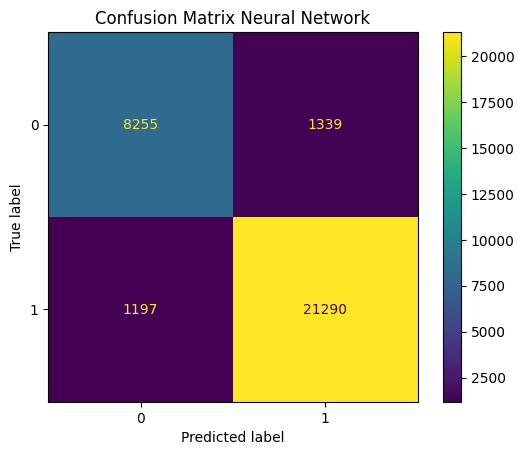

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
cm = confusion_matrix(y_true,pred)
print(cm)


disp = ConfusionMatrixDisplay.from_predictions(y_true=y_true,y_pred=pred,labels=[0,1])
disp.ax_.set_title("Confusion Matrix Neural Network")
plt.show()

In [74]:

X_train_final.shape

(181786, 2052)

In [76]:
X_test_final.shape

(32081, 2052)

In [77]:
X_train_final.shape[0]

181786

In [92]:
## Our input size is 2052 ---> 46 * 46 = 2116 
X_train_final.resize((X_train_final.shape[0],46,46,1))


In [97]:
X_test_final.resize((X_test_final.shape[0],46,46,1))

In [116]:
from keras.optimizers import Adam
kernel_number = 64
kernel_size = 3

model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters=kernel_number,kernel_size=kernel_size,strides=1,padding="valid",activation="elu",
                                  input_shape=(46,46,1)))
                                  
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100))
model.add(keras.layers.Dense(2,activation='softmax'))
model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["accuracy"])
    

In [117]:
model.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 46, 44, 64)        256       
                                                                 
 flatten_4 (Flatten)         (None, 129536)            0         
                                                                 
 dense_199 (Dense)           (None, 100)               12953700  
                                                                 
 dense_200 (Dense)           (None, 2)                 202       
                                                                 
Total params: 12,954,158
Trainable params: 12,954,158
Non-trainable params: 0
_________________________________________________________________


In [119]:
epoch = 2
history = model.fit(X_train_final,y_train_final,batch_size= 258,epochs= epoch,validation_data=(X_test_final,y_test_final),verbose=1)

Epoch 1/2
705/705 [==============================] - 415s 588ms/step - loss: 0.6084 - accuracy: 0.7012 - val_loss: 0.6123 - val_accuracy: 0.7009
Epoch 2/2
705/705 [==============================] - 392s 556ms/step - loss: 0.6078 - accuracy: 0.7012 - val_loss: 0.6119 - val_accuracy: 0.7009


In [120]:
pred = model.predict(X_test_final)
pred = np.argmax(pred,axis = 1)
y_true = np.argmax(y_test_final,axis=1)
print(metrics.classification_report(y_true,pred))

1003/1003 [==============================] - 77s 77ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9594
           1       0.70      1.00      0.82     22487

    accuracy                           0.70     32081
   macro avg       0.35      0.50      0.41     32081
weighted avg       0.49      0.70      0.58     32081



c:\Users\Rojan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rojan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rojan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

[[    0  9594]
 [    0 22487]]


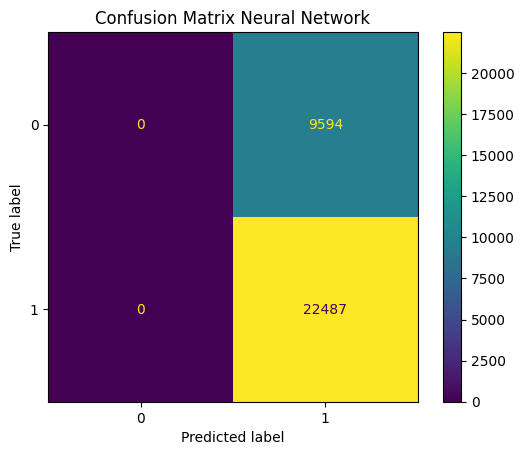

In [121]:
cm = confusion_matrix(y_true,pred)
print(cm)


disp = ConfusionMatrixDisplay.from_predictions(y_true=y_true,y_pred=pred,labels=[0,1])
disp.ax_.set_title("Confusion Matrix Neural Network")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train)